## Input parameters

In [25]:
batch_size = 32
learning_rate = 0.0005
noise_dim = 32 # dimension of random noise as generator's input
layers_dim = 128 # dimension at layers inside NN
epochs = 100+1
model_name = 'model'
noise_dim = 32

## Install libraries

In [26]:
import pandas as pd
import numpy as np
import sklearn.datasets as ds
from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import keras

import os
import sys

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import wasserstein_distance
from table_evaluator import load_data, TableEvaluator

## Prepare data

In [27]:
# Load data

dfdiabetes_x = pd.DataFrame(ds.load_diabetes().data)
dfdiabetes_x.columns = ds.load_diabetes().feature_names
dfdiabetes_y = pd.DataFrame(ds.load_diabetes().target)
dfdiabetes_y.columns = ['Outcome']
df = pd.concat([dfdiabetes_x,dfdiabetes_y], axis=1)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [28]:
# Scale data

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.800500,1.065488,1.297088,0.459840,-0.929746,-0.732065,-0.912451,-0.054499,0.418551,-0.370989,-0.014719
1,-0.039567,-0.938537,-1.082180,-0.553511,-0.177624,-0.402886,1.564414,-0.830301,-1.436551,-1.938479,-1.001659
2,1.793307,1.065488,0.934533,-0.119218,-0.958674,-0.718897,-0.680245,-0.054499,0.060207,-0.545154,-0.144580
3,-1.872441,-0.938537,-0.243771,-0.770658,0.256292,0.525397,-0.757647,0.721302,0.477072,-0.196823,0.699513
4,0.113172,-0.938537,-0.764944,0.459840,0.082726,0.327890,0.171178,-0.054499,-0.672582,-0.980568,-0.222496


## GAN

In [29]:
class GAN():
    
    def __init__(self, batch_size, learning_rate, noise_dim, data_dim, layers_dim):
        # Initialize input values
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.noise_dim = noise_dim
        self.data_dim = data_dim
        self.layers_dim = layers_dim
        
        def create_generator(batch_size, input_shape, layers_dim, data_dim):
            input = Input(shape=input_shape, batch_size=batch_size)
            x = Dense(layers_dim)(input)
            x = ReLU()(x)
            x = Dense(layers_dim * 2)(x)
            x = ReLU()(x)
            x = Dense(layers_dim * 4)(x)
            x = ReLU()(x)
            x = Dense(data_dim)(x)
            return Model(inputs=input, outputs=x)
    
        def create_discriminator(batch_size, input_shape, layers_dim):
            input = Input(shape=input_shape, batch_size=batch_size)
            x = Dense(layers_dim * 4)(input)
            x = LeakyReLU()(x)
            x = Dropout(0.1)(x)
            x = Dense(layers_dim * 2)(x)
            x = LeakyReLU()(x)
            x = Dropout(0.1)(x)
            x = Dense(layers_dim)(x)
            x = LeakyReLU()(x)
            x = Dense(1, activation='sigmoid')(x)
            return Model(inputs=input, outputs=x)
        
        self.generator = create_generator(self.batch_size, (self.noise_dim,), self.layers_dim, self.data_dim)
        self.discriminator = create_discriminator(self.batch_size, (self.data_dim,), self.layers_dim)
        
        # Adam optimizer
        opt = Adam(self.learning_rate)
        # Discriminator is a binary classification real/fake -> loss is binary crossentropy and metric accuracy
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])        
        
        # STRUCTURE
        def create_gan(self):
            # For the combined model, only train the generator
            self.discriminator.trainable = False
            
            gen_input = Input(shape=(self.noise_dim,)) # The generator takes noise as input
            gen_output = self.generator(gen_input)
            
            disc_output = self.discriminator(gen_output) # The discriminator takes generated images as input 
            
            # GAN model: generator + discriminator
            gan = Model(gen_input, disc_output)
            gan.compile(loss='binary_crossentropy', optimizer=opt)
            
            return gan
        
        self.gan = create_gan(self)

    def train(self, data, epochs, model_name):        
        ones = np.ones((self.batch_size, 1))
        zeros = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # First input: to the generator 
            noise = tensorflow.random.normal((self.batch_size, self.noise_dim)) #batch_size x noise_dim 
            # Generator - Noise inputs the generator 
            gen_data = self.generator.predict(noise)
            # Second input: to the discriminator from real data
            real_data = data.sample(n = batch_size).to_numpy()
             
            # Train the discriminator on both paths: from real data and from generated data
            # When data is real, it outputs 1; when data is generated, it outputs 0
            dloss_real = self.discriminator.train_on_batch(real_data, ones)
            dloss_gen = self.discriminator.train_on_batch(gen_data, zeros)
            d_loss = np.add(dloss_real, dloss_gen)/2
    
            # Train the generator to fool the discriminator
            # When data comes from noise and is generated, it outputs 1
            noise = tensorflow.random.normal((self.batch_size, self.noise_dim))
            g_loss = self.gan.train_on_batch(noise, ones)
    
            # Save losses from generator and discriminator
            genlosses.append(g_loss)
            disclosses.append(d_loss[0])
            
            # Plot the progress every 10 epochs
            if epoch % 10 == 0:
                print("Epoch %d with discriminator loss %f and generator loss %f (x100)" % (epoch, d_loss[0]*100, g_loss*100))
                        
            # Save model every 100 epochs
            if epoch % 100 == 0:
                self.generator.save_weights(model_name + '/gen_weights_' + str(epoch) + '.h5')
                self.discriminator.save_weights(model_name + '/disc_weights_' + str(epoch) + '.h5')
            noise = tensorflow.random.normal((123, self.noise_dim))
            gen_data = self.generator(noise)
    
    # Save generator weights
    def save(self, path):
        self.generator.save_weights(path)

## GAN training

In [30]:
genlosses = []
disclosses = []
data_dim = df.shape[1]

if not os.path.exists(model_name):
    os.mkdir(model_name)

model = GAN(batch_size, learning_rate, noise_dim, data_dim, layers_dim)
model.train(df, epochs, model_name)
model.save(model_name + '/gan/saved/generator')

Epoch 0 with discriminator loss 70.458123 and generator loss 66.870987 (x100)
Epoch 10 with discriminator loss 45.989695 and generator loss 80.650127 (x100)
Epoch 20 with discriminator loss 23.207656 and generator loss 248.392820 (x100)
Epoch 30 with discriminator loss 30.629553 and generator loss 164.112902 (x100)
Epoch 40 with discriminator loss 33.996888 and generator loss 300.038767 (x100)
Epoch 50 with discriminator loss 8.703813 and generator loss 390.917683 (x100)
Epoch 60 with discriminator loss 28.160881 and generator loss 232.338619 (x100)
Epoch 70 with discriminator loss 35.502076 and generator loss 189.431763 (x100)
Epoch 80 with discriminator loss 27.805199 and generator loss 250.031352 (x100)
Epoch 90 with discriminator loss 8.365969 and generator loss 246.969175 (x100)
Epoch 100 with discriminator loss 10.177345 and generator loss 213.436818 (x100)


## Training output

<AxesSubplot:title={'center':'Loss Functions'}>

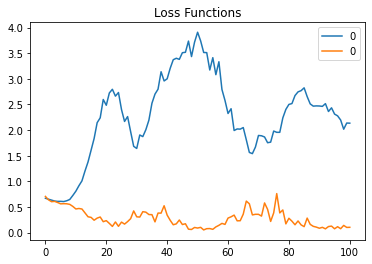

In [31]:
# Loss functions

fig, ax = plt.subplots()
pd.DataFrame(genlosses).plot(ax=ax, title='Loss Functions')
pd.DataFrame(disclosses).plot(ax=ax)

In [32]:
# Generator schema

model.generator.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(32, 32)]                0         
                                                                 
 dense_24 (Dense)            (32, 128)                 4224      
                                                                 
 re_lu_9 (ReLU)              (32, 128)                 0         
                                                                 
 dense_25 (Dense)            (32, 256)                 33024     
                                                                 
 re_lu_10 (ReLU)             (32, 256)                 0         
                                                                 
 dense_26 (Dense)            (32, 512)                 131584    
                                                                 
 re_lu_11 (ReLU)             (32, 512)                 0   

In [33]:
# Discriminator schema

model.discriminator.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(32, 11)]                0         
                                                                 
 dense_28 (Dense)            (32, 512)                 6144      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (32, 512)                 0         
                                                                 
 dropout_6 (Dropout)         (32, 512)                 0         
                                                                 
 dense_29 (Dense)            (32, 256)                 131328    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (32, 256)                 0         
                                                                 
 dropout_7 (Dropout)         (32, 256)                 0  

In [34]:
# GAN schema

model.gan.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32)]              0         
                                                                 
 model_9 (Functional)        (32, 11)                  174475    
                                                                 
 model_10 (Functional)       (32, 1)                   170497    
                                                                 
Total params: 344,972
Trainable params: 174,475
Non-trainable params: 170,497
_________________________________________________________________


## Tabular data generation

In [35]:
test_size = len(df) # number of generated cases
noise = np.random.normal(size=(test_size, noise_dim))
generator_model = model.generator
generator_model.load_weights(model_name+'/gen_weights_'+str(epochs-1)+'.h5')

g_z = generator_model.predict(noise)
dfgen = pd.DataFrame(g_z, columns=df.columns)
dfgen.to_csv(model_name+'/Generated_data.csv')

dfgen.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.198625,0.183266,-0.122381,-0.575788,-0.010439,0.080595,0.236567,0.285341,-0.304586,-0.230943,0.207064
1,0.210397,0.230164,-0.065342,-0.748242,-0.099922,0.048380,0.388803,0.371215,-0.273231,-0.211331,0.205235
2,0.293597,0.247437,-0.126341,-0.864972,-0.034357,0.069463,0.366480,0.460444,-0.428374,-0.358592,0.295668
3,0.146937,0.134358,-0.040694,-0.534037,-0.011681,-0.021894,0.219854,0.240662,-0.241925,-0.223623,0.145236
4,0.162401,0.171827,-0.064525,-0.552690,-0.052350,0.047953,0.263088,0.272985,-0.236088,-0.180742,0.169739


## Testing

In [75]:
# Wasserstein distance

wd = []
for c in df.columns:
    wdistance = wasserstein_distance(df[c], dfgen[c])
    wd.append(wdistance)

distances = pd.DataFrame(np.array(wd), np.array(df.columns), columns = ['Distance'])
distances = distances.reset_index()
distances.columns = ['Variable', 'Distance']

print(distances) 
print('\nMean Wasserstein Distance:', np.mean(wd))

   Variable  Distance
0       age  0.778674
1       sex  0.968211
2       bmi  0.774253
3        bp  0.805982
4        s1  0.758080
5        s2  0.770195
6        s3  0.789851
7        s4  0.812820
8        s5  0.768461
9        s6  0.748201
10  Outcome  0.841081

Mean Wasserstein Distance: 0.8014370748659545


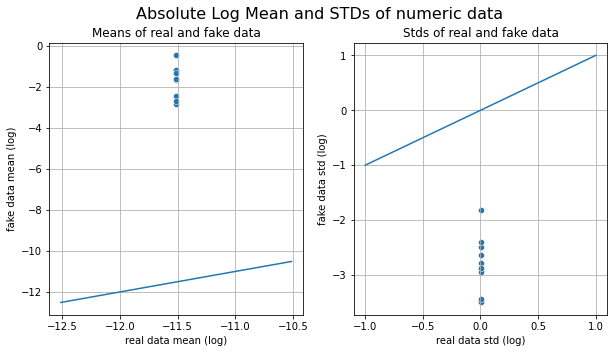

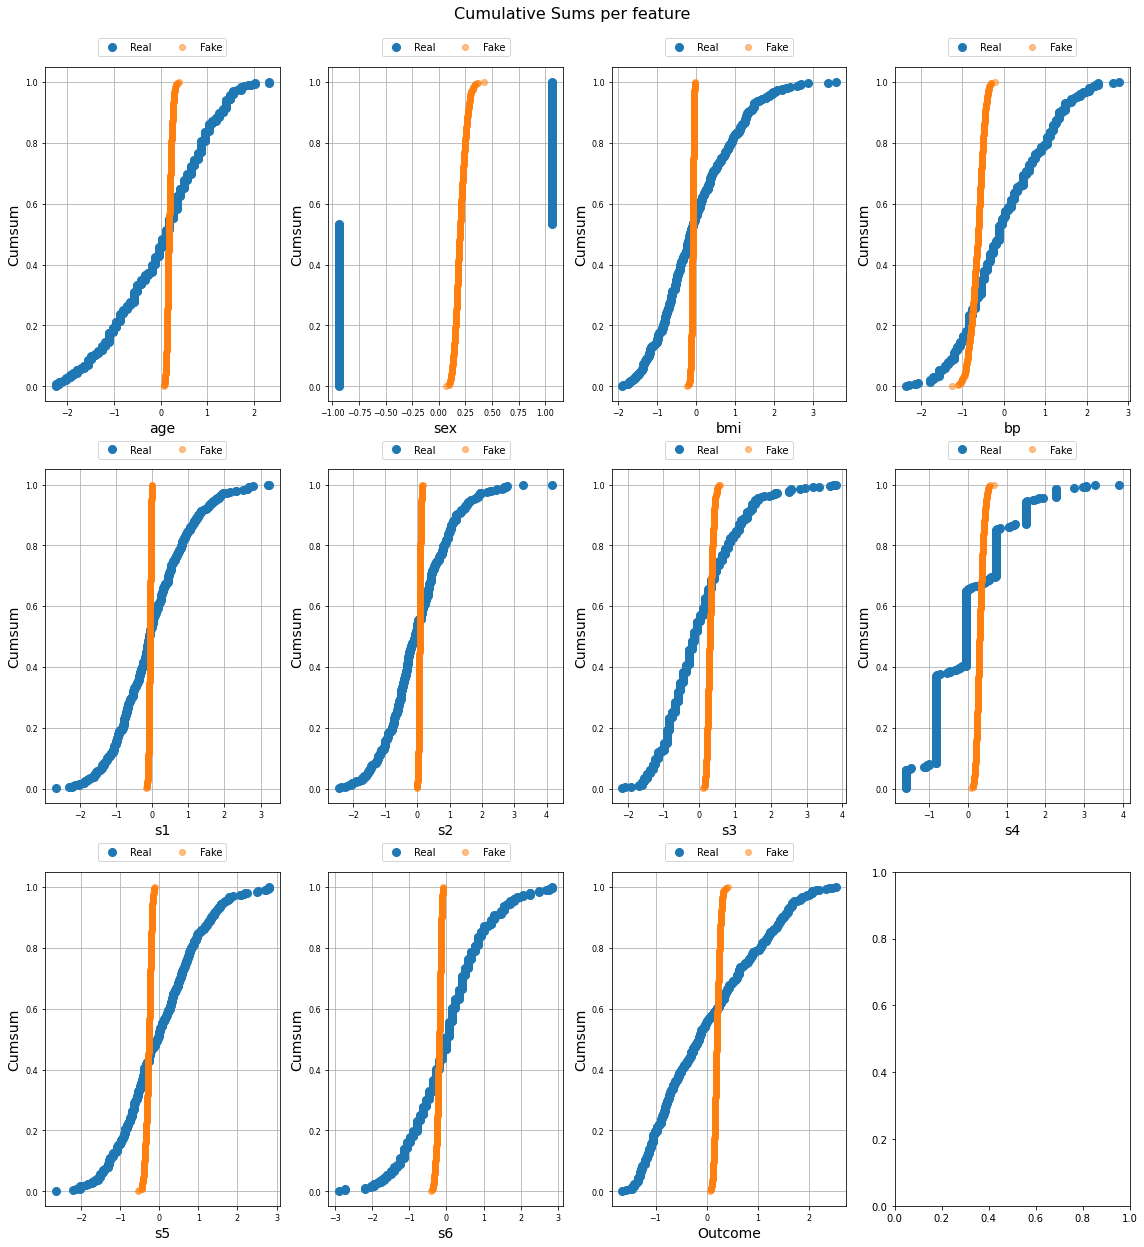

C:\Users\evaju\anaconda3\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
C:\Users\evaju\anaconda3\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
C:\Users\evaju\anaconda3\lib\site-packages\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['r

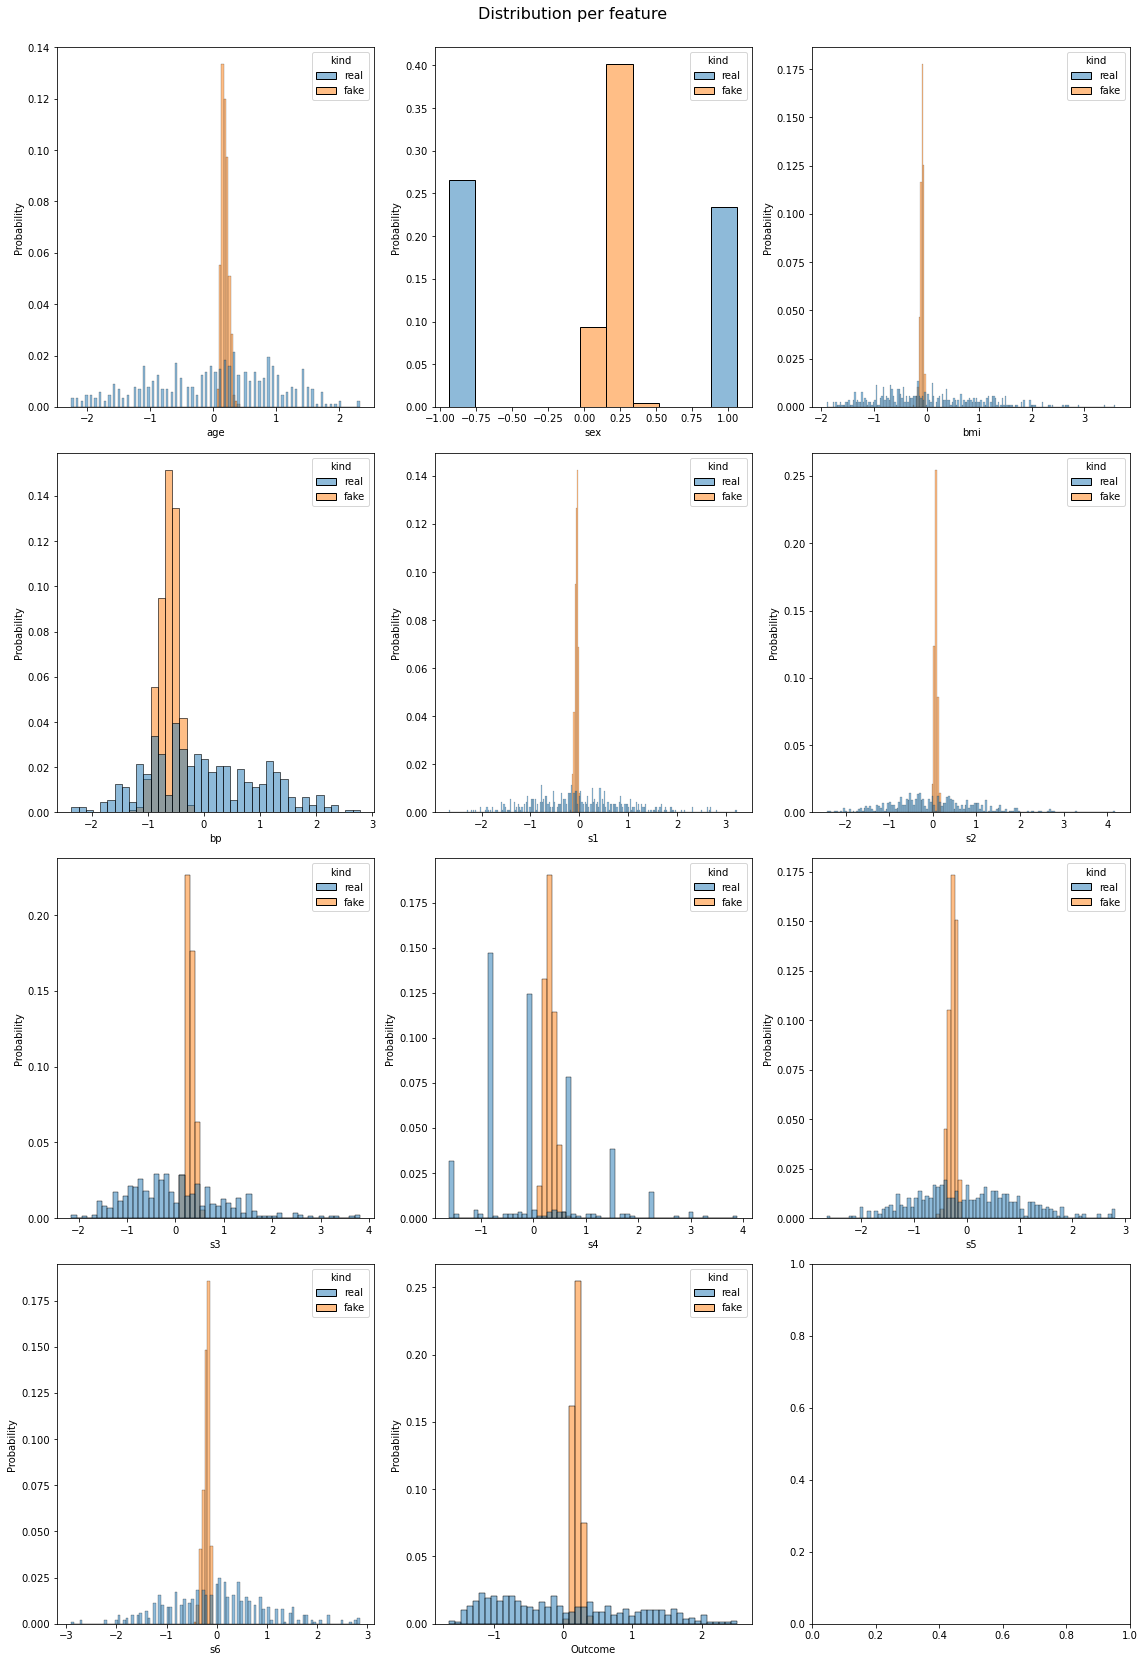

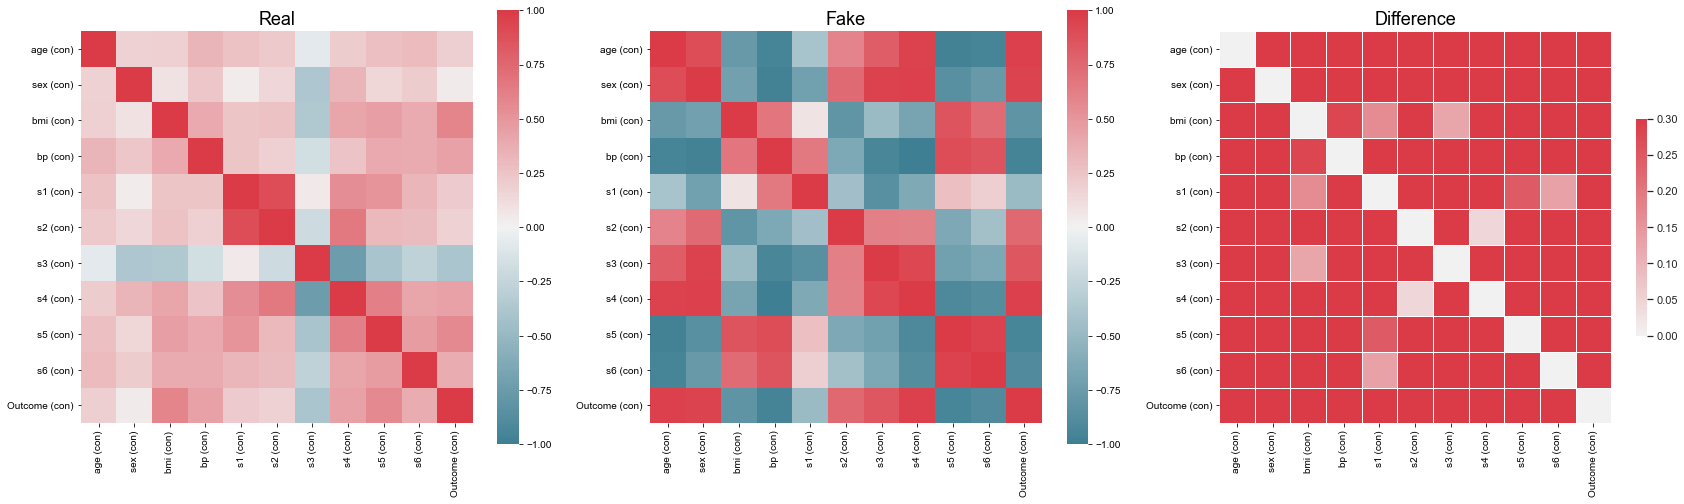

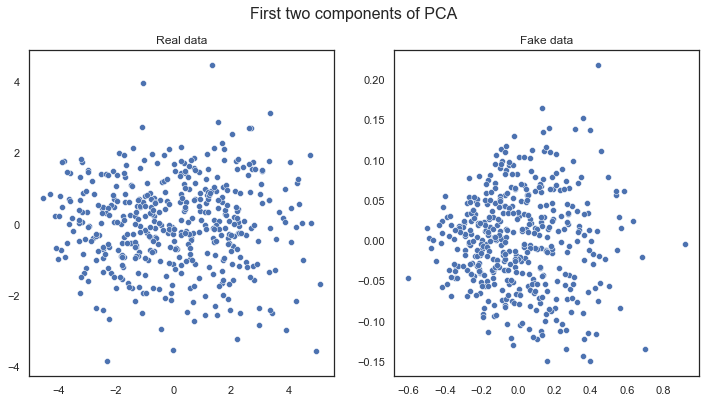

In [76]:
# Visual metrics

table_evaluator = TableEvaluator(df, dfgen)
table_evaluator.visual_evaluation()

## Save unstandarized generated dataset

In [77]:
dfgen_inv = pd.DataFrame(scaler.inverse_transform(dfgen), columns=dfgen.columns)
dfgen_inv.to_csv(model_name+'/Unstandarized_Generated_data.csv')

dfgen_inv.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.009448,0.008717,-0.005821,-0.027387,-0.000497,0.003833,0.011252,0.013572,-0.014488,-0.010985,168.078613
1,0.010008,0.010948,-0.003108,-0.035590,-0.004753,0.002301,0.018493,0.017657,-0.012996,-0.010052,167.937744
2,0.013965,0.011769,-0.006009,-0.041143,-0.001634,0.003304,0.017432,0.021901,-0.020376,-0.017056,174.901657
3,0.006989,0.006391,-0.001936,-0.025402,-0.000556,-0.001041,0.010457,0.011447,-0.011507,-0.010637,163.317490
4,0.007725,0.008173,-0.003069,-0.026289,-0.002490,0.002281,0.012514,0.012985,-0.011230,-0.008597,165.204346
